# Features engineer

# Train on rank transform groupby cell line

In [ ]:
import os
import json
import random
import pickle   # ✅ 新增
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from datetime import datetime

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  EXPERIMENT CONFIGURATION
# ============================================================
EXPERIMENT_DIR = "../results/lgbm/all_rank_features"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/X2_all_rank_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")

# ✅ 如果已有舊的 log.txt，直接覆蓋（清空）
with open(LOG_PATH, "w") as f:
    f.write("")  # 或寫入 header，如 "==== New Experiment ====\n"

def log(msg):
    """同時印出並寫入 log.txt"""
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")


log(f"🚀 Experiment started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
log(f"Experiment directory: {EXPERIMENT_DIR}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

feature_cols = [c for c in df_train_full.columns if c not in META_COLS]
log(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  K-FOLD DEFINITION
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

log("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    log(f"Fold {i+1}: {fset}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,
    "force_row_wise": True,
}

# ============================================================
#                  SAVE CONFIG
# ============================================================
config = {
    "train_path": TRAIN_PATH,
    "val_path": VAL_PATH,
    "seed": SEED,
    "params": params,
    "folds": folds,
    "target_col": TARGET_COL,
}
with open(os.path.join(EXPERIMENT_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

# ============================================================
#                  TRAINING
# ============================================================
results = []
preds_all = []

preds_all = []

for fold_idx, val_chrs in enumerate(folds):
    log(f"\n🚀 Fold {fold_idx+1}/{len(folds)} | Val chromosomes: {val_chrs}")
    fold_dir = os.path.join(EXPERIMENT_DIR, f"fold_{fold_idx+1}")
    os.makedirs(fold_dir, exist_ok=True)

    # Split
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # ✅ 保留原始 index，方便之後對齊
    df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # Save model (.pkl)
    model_path = os.path.join(fold_dir, "model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    log(f"💾 Model saved: {model_path}")

    # Predict
    df_val["predicted_gex_rank"] = model.predict(X_val, num_iteration=model.best_iteration)
    df_val["fold_id"] = fold_idx + 1  # optional: fold 來源

    preds_all.append(df_val[["orig_idx", "gene_name", "predicted_gex_rank", "fold_id"]])

    # Evaluate
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["predicted_gex_rank"])[0]
    log(f"📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")
    log("📊 Per-Chromosome Spearman:")
    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["predicted_gex_rank"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        log(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SAVE PREDICTIONS & SUMMARY
# ============================================================

# ============================================================
# 🔁 合併並依照原始順序還原
# ============================================================
df_preds_all = pd.concat(preds_all, ignore_index=True)
df_preds_all = df_preds_all.sort_values("orig_idx").reset_index(drop=True)

# 驗證對齊
assert len(df_preds_all) == len(df_val_full)
assert (df_preds_all["gene_name"].values == df_val_full["gene_name"].values).all(), \
    "❌ Prediction order mismatch with df_val_full!"

# ✅ 輸出只有 gene_name + predicted_gex_rank
df_preds_all[["gene_name", "predicted_gex_rank"]].to_csv(
    os.path.join(EXPERIMENT_DIR, "predict_val.tsv"), sep="\t", index=False
)
log("💾 Final predictions (aligned) saved (predict_val.tsv)")

# ✅ 全域 Spearman：用原始 df_val_full 的真值 vs 你的預測
overall_val_spearman = spearmanr(
    df_val_full["gex_rank"], 
    df_preds_all["predicted_gex_rank"]
)[0]
log(f"🌍 Overall validation Spearman (aligned) = {overall_val_spearman:.4f}")




summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean()
chr_mean.rename(columns={"spearman": "mean_spearman"}, inplace=True)

summary_output = summary_fold.merge(chr_mean, how="cross")
summary_output.to_csv(os.path.join(EXPERIMENT_DIR, "summary.tsv"), sep="\t", index=False)

log("💾 Summary saved (summary.tsv)")
log(f"Mean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")
log(f"Overall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")

log(f"\n✅ Experiment finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🔒 Global seed set to 42
🚀 Experiment started at 2025-10-13 22:27:52
Experiment directory: ../results/lgbm/all_rank_features
Feature count: 456
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1/5 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.120455	val's rmse: 0.197202
Early stopping, best iteration is:
[181]	train's rmse: 0.122437	val's rmse: 0.196494
💾 Model saved: ../results/lgbm/all_rank_features/fold_1/model.pkl
📈 Fold 1 Overall Spearman ρ = 0.7468
📊 Per-Chromosome Spearman:
   chr12 : ρ = 0.7557
   chr17 : ρ = 0.7452
   chr2  : ρ = 0.7338
   chr22 : ρ = 0.7400
   chr7  : ρ = 0.7587

🚀 Fold 2/5 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores 

KeyboardInterrupt: 

In [ ]:
import os
import json
import pickle
import shap
import pandas as pd
import numpy as np

def summarize_shap_feature_ranking_from_config(experiment_dir, sample_size=None):
    """
    根據 experiment_dir 下的 config.json，自動載入資料與模型，
    為每個 fold 計算 SHAP importance 並彙總排名。
    
    Parameters
    ----------
    experiment_dir : str
        實驗資料夾（需包含 config.json 與 fold_x/model.pkl）
    sample_size : int or None, default=None
        若為 None，則使用整個 validation fold 的資料。
        若指定數字，則從該 fold 抽樣 sample_size 筆資料以加速計算。
    """

    # ============================================================
    # 1️⃣ 讀取設定
    # ============================================================
    config_path = os.path.join(experiment_dir, "config.json")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"❌ config.json not found in {experiment_dir}")

    with open(config_path, "r") as f:
        config = json.load(f)

    train_path = config["train_path"]
    val_path = config["val_path"]
    folds = config["folds"]
    feature_cols = config["feature_cols"]
    print(f"📖 Loaded config from: {config_path}")
    print(f"   Train path: {train_path}")
    print(f"   Val path: {val_path}")
    print(f"   # of folds: {len(folds)}")

    # ============================================================
    # 2️⃣ 載入資料
    # ============================================================
    df_val_full   = pd.read_csv(val_path, sep="\t")

    # ============================================================
    # 3️⃣ 逐 fold 計算 SHAP
    # ============================================================
    fold_dirs = sorted(
        [os.path.join(experiment_dir, d) for d in os.listdir(experiment_dir) if d.startswith("fold_")]
    )
    if not fold_dirs:
        raise FileNotFoundError("No fold_* directories found under experiment_dir")

    results = []

    for fold_idx, (fold_path, val_chrs) in enumerate(zip(fold_dirs, folds), start=1):
        model_path = os.path.join(fold_path, "model.pkl")
        if not os.path.exists(model_path):
            print(f"⚠️ Skipping {fold_path}, no model.pkl found.")
            continue

        print(f"\n🧠 Fold {fold_idx}: loading model → {model_path}")
        with open(model_path, "rb") as f:
            model = pickle.load(f)

        # 選擇對應 validation chromosomes
        df_val_fold = df_val_full[df_val_full["chr"].isin(val_chrs)]
        print(f"   Using validation chromosomes: {val_chrs} ({len(df_val_fold)} samples)")

        if len(df_val_fold) == 0:
            print(f"⚠️ Fold {fold_idx} validation set empty, skipping.")
            continue

        # 抽樣或使用全部
        if sample_size is None:
            X_sample = df_val_fold[feature_cols].values
            print(f"   Using full validation fold ({len(X_sample)} samples) for SHAP.")
        else:
            X_sample = df_val_fold[feature_cols].sample(
                min(sample_size, len(df_val_fold)),
                random_state=config.get("seed", 42)
            ).values
            print(f"   Using {len(X_sample)} sampled rows for SHAP (sample_size={sample_size})")

        # SHAP 計算
        explainer = shap.TreeExplainer(
            model,
            feature_perturbation="interventional",
            model_output="raw"
        )
        shap_values = explainer(X_sample, check_additivity=False).values

        # 平均絕對 SHAP 值
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        df_fold = pd.DataFrame({
            "feature": feature_cols,
            f"fold_{fold_idx}_mean_abs_shap": mean_abs_shap
        })
        df_fold[f"fold_{fold_idx}_rank"] = df_fold[f"fold_{fold_idx}_mean_abs_shap"].rank(
            ascending=False, method="min"
        )
        results.append(df_fold)

    # ============================================================
    # 4️⃣ 整合所有 fold 結果
    # ============================================================
    print("\n🧩 Merging results across folds...")
    df_merge = results[0][["feature"]].copy()
    for df_fold in results:
        df_merge = df_merge.merge(df_fold, on="feature", how="outer")

    shap_cols = [c for c in df_merge.columns if c.endswith("_mean_abs_shap")]
    rank_cols = [c for c in df_merge.columns if c.endswith("_rank")]

    df_merge["mean_abs_shap_all"] = df_merge[shap_cols].mean(axis=1)
    df_merge["mean_rank_all"] = df_merge[rank_cols].mean(axis=1)
    df_merge = df_merge.sort_values("mean_rank_all")

    # ============================================================
    # 5️⃣ 儲存結果
    # ============================================================
    out_path = os.path.join(experiment_dir, "shap_feature_summary.tsv")
    df_merge.to_csv(out_path, sep="\t", index=False)
    print(f"\n💾 SHAP summary saved: {out_path}")

    return df_merge


In [100]:
experiment_dir = "../results/lgbm/pruned_X1&X2_4_features"

shap_summary = summarize_shap_feature_ranking_from_config(
    experiment_dir,
    # sample_size=2000
)


📖 Loaded config from: ../results/lgbm/pruned_X1&X2_4_features/config.json
   Train path: ../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv
   Val path: ../preprocessed_data/CAGE-merged/X2_all_rank_features.tsv
   # of folds: 5

🧠 Fold 1: loading model → ../results/lgbm/pruned_X1&X2_4_features/fold_1/model.pkl
   Using validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22'] (4641 samples)
   Using full validation fold (4641 samples) for SHAP.


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(



🧠 Fold 2: loading model → ../results/lgbm/pruned_X1&X2_4_features/fold_2/model.pkl
   Using validation chromosomes: ['chr3', 'chr8', 'chr13', 'chr18'] (2258 samples)
   Using full validation fold (2258 samples) for SHAP.

🧠 Fold 3: loading model → ../results/lgbm/pruned_X1&X2_4_features/fold_3/model.pkl
   Using validation chromosomes: ['chr4', 'chr9', 'chr14', 'chr19'] (3453 samples)
   Using full validation fold (3453 samples) for SHAP.


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(
/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(



🧠 Fold 4: loading model → ../results/lgbm/pruned_X1&X2_4_features/fold_4/model.pkl
   Using validation chromosomes: ['chr5', 'chr10', 'chr15', 'chr20'] (2652 samples)
   Using full validation fold (2652 samples) for SHAP.

🧠 Fold 5: loading model → ../results/lgbm/pruned_X1&X2_4_features/fold_5/model.pkl
   Using validation chromosomes: ['chr6', 'chr11', 'chr16', 'chr21'] (3280 samples)
   Using full validation fold (3280 samples) for SHAP.


/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(
/opt/anaconda3/envs/ml4g_project1/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(



🧩 Merging results across folds...

💾 SHAP summary saved: ../results/lgbm/pruned_X1&X2_4_features/shap_feature_summary.tsv


In [106]:
import os
import json
import random
import pickle   # ✅ 新增
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from datetime import datetime

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  EXPERIMENT CONFIGURATION
# ============================================================
EXPERIMENT_DIR = "../results/lgbm/pruned_X2&X1_4_top200_features"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/X2_all_rank_features.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"
feature_cols = shap_summary["feature"][:200].tolist()

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")

# ✅ 如果已有舊的 log.txt，直接覆蓋（清空）
with open(LOG_PATH, "w") as f:
    f.write("")  # 或寫入 header，如 "==== New Experiment ====\n"

def log(msg):
    """同時印出並寫入 log.txt"""
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")


log(f"🚀 Experiment started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
log(f"Experiment directory: {EXPERIMENT_DIR}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

log(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  K-FOLD DEFINITION
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

log("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    log(f"Fold {i+1}: {fset}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,
    "force_row_wise": True,
}

# ============================================================
#                  SAVE CONFIG
# ============================================================
config = {
    "train_path": TRAIN_PATH,
    "val_path": VAL_PATH,
    "seed": SEED,
    "params": params,
    "folds": folds,
    "target_col": TARGET_COL,
    "feature_cols": feature_cols
}
with open(os.path.join(EXPERIMENT_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

# ============================================================
#                  TRAINING
# ============================================================
results = []
preds_all = []

preds_all = []

for fold_idx, val_chrs in enumerate(folds):
    log(f"\n🚀 Fold {fold_idx+1}/{len(folds)} | Val chromosomes: {val_chrs}")
    fold_dir = os.path.join(EXPERIMENT_DIR, f"fold_{fold_idx+1}")
    os.makedirs(fold_dir, exist_ok=True)

    # Split
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # ✅ 保留原始 index，方便之後對齊
    df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # Save model (.pkl)
    model_path = os.path.join(fold_dir, "model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    log(f"💾 Model saved: {model_path}")

    # Predict
    df_val["predicted_gex_rank"] = model.predict(X_val, num_iteration=model.best_iteration)
    df_val["fold_id"] = fold_idx + 1  # optional: fold 來源

    preds_all.append(df_val[["orig_idx", "gene_name", "predicted_gex_rank", "fold_id"]])

    # Evaluate
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["predicted_gex_rank"])[0]
    log(f"📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")
    log("📊 Per-Chromosome Spearman:")
    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["predicted_gex_rank"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        log(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SAVE PREDICTIONS & SUMMARY
# ============================================================

# ============================================================
# 🔁 合併並依照原始順序還原
# ============================================================
df_preds_all = pd.concat(preds_all, ignore_index=True)
df_preds_all = df_preds_all.sort_values("orig_idx").reset_index(drop=True)

# 驗證對齊
assert len(df_preds_all) == len(df_val_full)
assert (df_preds_all["gene_name"].values == df_val_full["gene_name"].values).all(), \
    "❌ Prediction order mismatch with df_val_full!"

# ✅ 輸出只有 gene_name + predicted_gex_rank
df_preds_all[["gene_name", "predicted_gex_rank"]].to_csv(
    os.path.join(EXPERIMENT_DIR, "predict_val.tsv"), sep="\t", index=False
)
log("💾 Final predictions (aligned) saved (predict_val.tsv)")

# ✅ 全域 Spearman：用原始 df_val_full 的真值 vs 你的預測
overall_val_spearman = spearmanr(
    df_val_full["gex_rank"], 
    df_preds_all["predicted_gex_rank"]
)[0]
log(f"🌍 Overall validation Spearman (aligned) = {overall_val_spearman:.4f}")




summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean()
chr_mean.rename(columns={"spearman": "mean_spearman"}, inplace=True)

# summary_output = summary_fold.merge(chr_mean, how="cross")
# summary_output.to_csv(os.path.join(EXPERIMENT_DIR, "summary.tsv"), sep="\t", index=False)

# log("💾 Summary saved (summary.tsv)")
log(f"Mean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")
log(f"Overall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")

log(f"\n✅ Experiment finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🔒 Global seed set to 42
🚀 Experiment started at 2025-10-13 23:16:06
Experiment directory: ../results/lgbm/pruned_X2&X1_4_top200_features
Feature count: 200
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1/5 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.130007	val's rmse: 0.164025
Early stopping, best iteration is:
[181]	train's rmse: 0.132045	val's rmse: 0.163538
💾 Model saved: ../results/lgbm/pruned_X2&X1_4_top200_features/fold_1/model.pkl
📈 Fold 1 Overall Spearman ρ = 0.7493
📊 Per-Chromosome Spearman:
   chr12 : ρ = 0.7546
   chr17 : ρ = 0.7429
   chr2  : ρ = 0.7485
   chr22 : ρ = 0.7801
   chr7  : ρ = 0.7316

🚀 Fold 2/5 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Trainin

X_pruned

In [ ]:
X_pruned.columns.tolist() --- IGNORE ---

,DNase_gene_z_mean,DNase_gene_z_std,DNase_gene_z_min,DNase_gene_z_max,DNase_gene_slope,DNase_gene_kurtosis,DNase_gene_skewness,DNase_gene_entropy,DNase_gene_autocorr,DNase_tss_z_mean,...,H3K4me3_axis_sum_rank,H3K4me3_promoter_body_delta_rank,H3K27me3_axis_sum_rank,H3K27me3_promoter_body_delta_rank,H3K36me3_axis_sum_rank,H3K36me3_promoter_body_delta_rank,H3K4me1_axis_sum_rank,H3K4me1_promoter_body_delta_rank,H3K9me3_axis_sum_rank,H3K9me3_promoter_body_delta_rank
0,0.584151,1.388399,-0.182493,14.454764,-1.954635e-05,48.834621,6.397811,13.371978,0.999240,0.269326,...,0.591624,0.054409,0.870978,0.647691,0.957381,0.963215,0.944485,0.948293,0.672623,0.482989
1,-0.010351,0.880571,-0.182493,21.448132,4.313167e-07,347.842712,17.320192,16.097462,0.999453,5.717640,...,0.752763,0.830816,0.521555,0.876320,0.421887,0.551216,0.649226,0.844817,0.647384,0.700074
2,0.471758,1.713748,-0.182493,12.340487,-5.204727e-05,25.592316,4.948495,11.716041,0.999371,1.731967,...,0.719111,0.670290,0.677045,0.297838,0.795873,0.143515,0.733604,0.815770,0.736920,0.611398
3,1.162646,1.682698,-0.182493,8.762506,-6.445720e-05,4.464489,2.104419,12.132165,0.998968,2.041904,...,0.809076,0.179993,0.994412,0.457074,0.703267,0.157639,0.987657,0.993982,0.761115,0.804041
4,0.398714,1.356963,-0.182493,16.406399,8.235264e-07,59.276760,6.943876,15.170340,0.999298,4.073930,...,0.737902,0.792311,0.505957,0.274810,0.558094,0.242447,0.895542,0.846905,0.190678,0.984033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16279,0.089465,0.606209,-0.182493,6.973515,4.636684e-07,56.857590,6.689626,15.272216,0.998558,-0.112792,...,0.253316,0.233911,0.322095,0.267072,0.653771,0.586772,0.311656,0.341808,0.141734,0.545566
16280,0.420331,1.839894,-0.182493,24.538225,-1.197764e-05,92.328056,8.917539,13.503240,0.999515,0.418046,...,0.794522,0.810059,0.695836,0.580386,0.839536,0.189450,0.743429,0.878224,0.086527,0.030889
16281,0.216317,1.383840,-0.182493,18.195389,-3.865250e-06,94.363045,8.861007,13.528787,0.998816,0.006785,...,0.472918,0.506694,0.348747,0.277942,0.558708,0.874846,0.934660,0.954679,0.594633,0.595922
16282,0.495430,1.514179,-0.182493,11.852601,2.706486e-05,27.506994,4.893925,12.770041,0.999210,2.800410,...,0.662245,0.695652,0.805269,0.831737,0.678396,0.112994,0.907025,0.951855,0.795505,0.626689


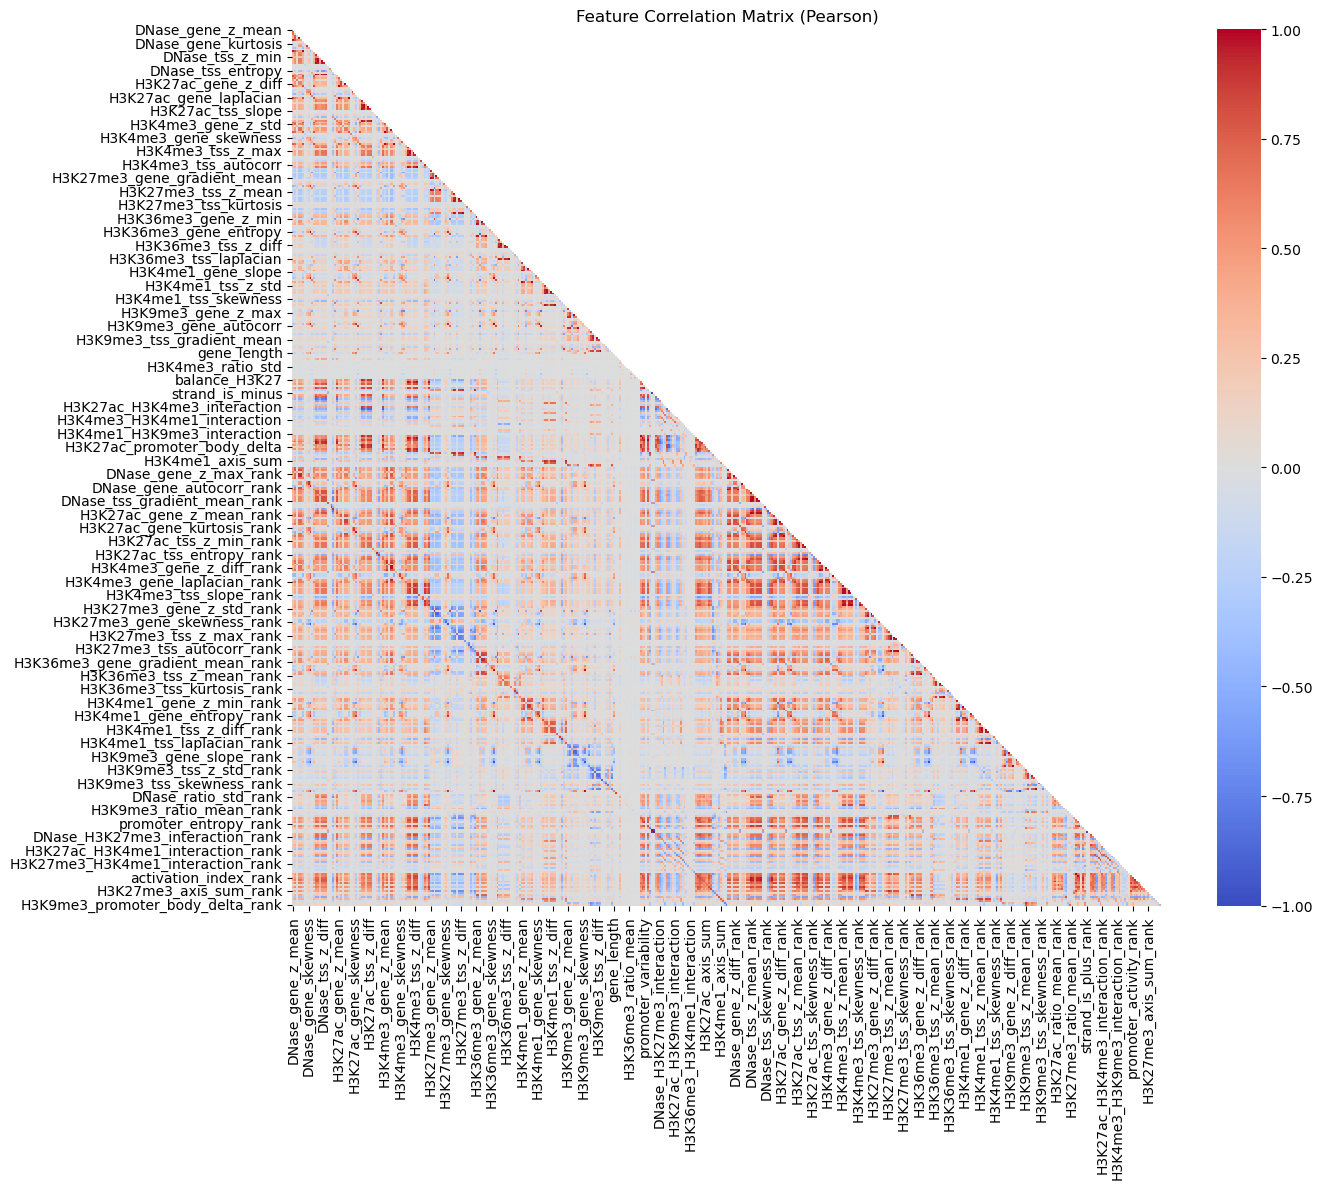

🧩 Found 243 highly correlated feature pairs (|r| > 0.95):
                               feature_1                     feature_2  \
66640                       balance_H3K4             promoter_activity   
102778                 balance_H3K4_rank        promoter_activity_rank   
102733                balance_H3K27_rank       activation_balance_rank   
66367                      balance_H3K27            activation_balance   
68456                    strand_is_minus          strand_is_minus_rank   
68189                     strand_is_plus           strand_is_plus_rank   
78992      DNase_gene_gradient_mean_rank     DNase_gene_laplacian_rank   
98492    H3K4me1_gene_gradient_mean_rank   H3K4me1_gene_laplacian_rank   
31350                H3K27me3_gene_z_max          H3K27me3_gene_z_diff   
95744   H3K36me3_gene_gradient_mean_rank  H3K36me3_gene_laplacian_rank   
92420   H3K27me3_gene_gradient_mean_rank  H3K27me3_gene_laplacian_rank   
81590       DNase_tss_gradient_mean_rank      DNase_ts

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

TRAIN_PATH = "../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

# 讀取資料
df_train = pd.read_csv(TRAIN_PATH, sep="\t")

# 選取特徵欄位
feature_cols = [c for c in df_train.columns if c not in META_COLS]
X = df_train[feature_cols]

# 計算 Pearson correlation matrix
corr_matrix = X.corr(method="pearson")

# --- 可視化上三角矩陣 ---
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix (Pearson)")
plt.tight_layout()
plt.show()

# --- 找出高度相關的特徵對 ---
threshold = 0.95  # 自行調整
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ["feature_1", "feature_2", "correlation"]
high_corr_pairs = high_corr_pairs[high_corr_pairs["correlation"].abs() > threshold]

print(f"🧩 Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > {threshold}):")
print(high_corr_pairs.sort_values("correlation", ascending=False).head(20))


✅ Loaded 456 features.
   X1 shape: (16284, 465), X2 shape: (16284, 465)

🧩 X1: Found 243 highly correlated pairs (|r| > 0.95)
🧩 X2: Found 247 highly correlated pairs (|r| > 0.95)

🧩 X1 high corr features: 190
🧩 X2 high corr features: 205
🔗 Intersection (both X1 & X2 highly correlated): 179
✅ Remaining features after pruning: 277 (removed 179)
💾 Saved pruned datasets:
   → X1_all_rank_features_pruned.tsv
   → X2_all_rank_features_pruned.tsv


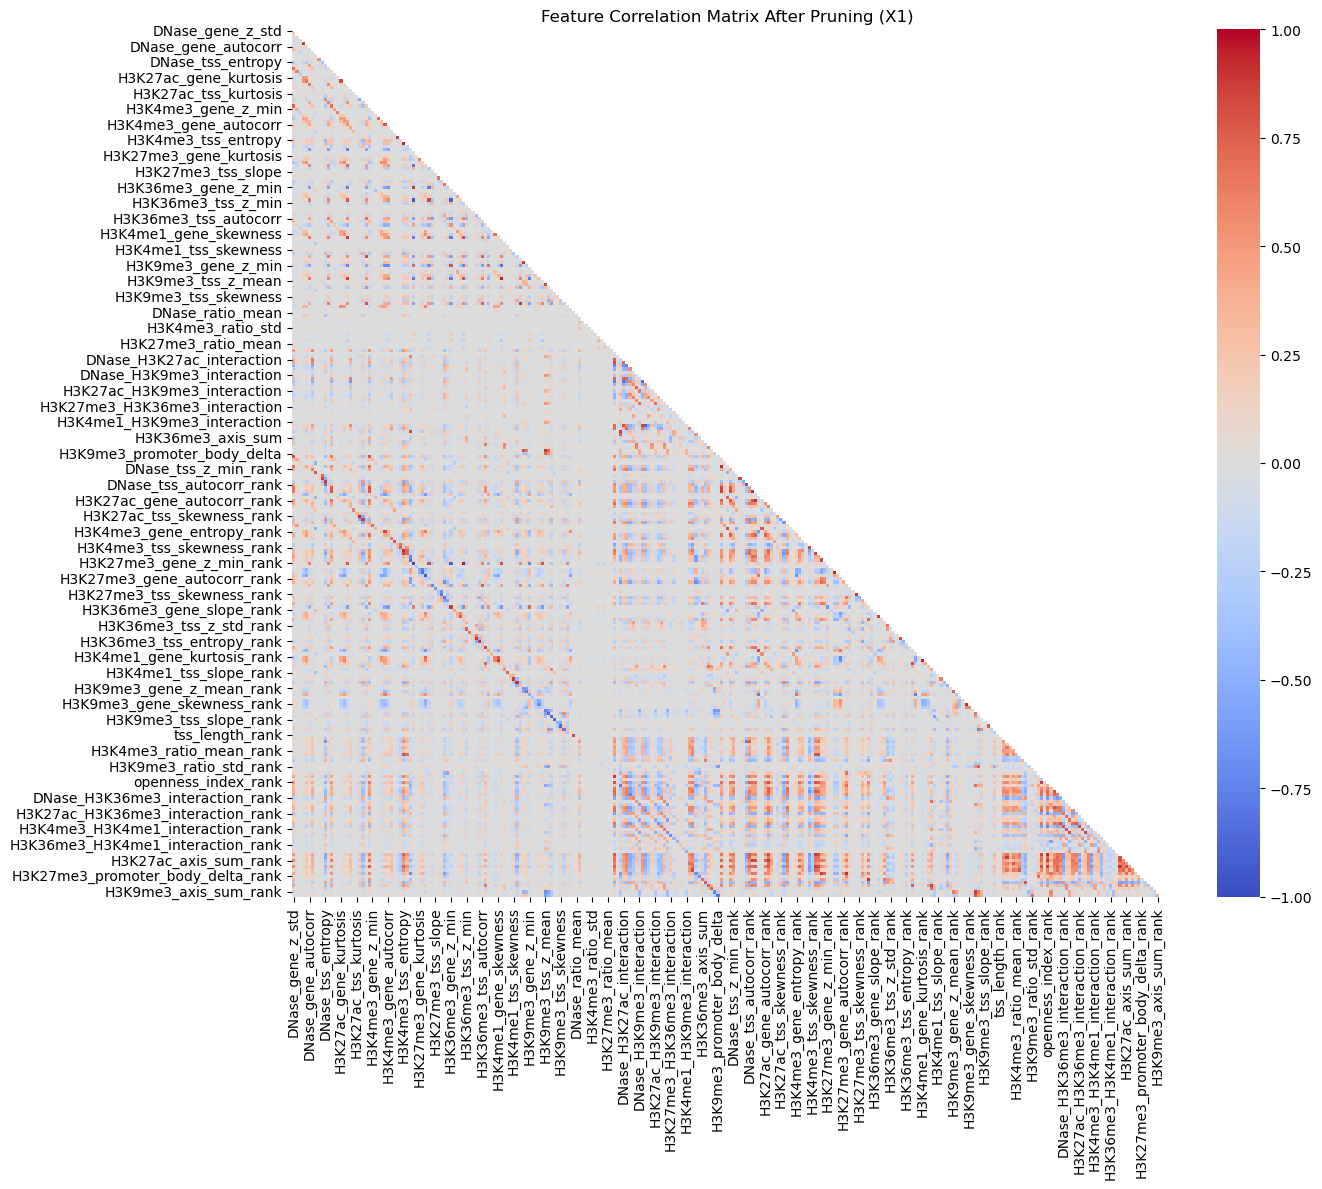

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
TRAIN_PATH_1 = "../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv"
TRAIN_PATH_2 = "../preprocessed_data/CAGE-merged/X2_all_rank_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

THRESHOLD = 0.95  # 高相關閾值

# ============================================================
# LOAD DATA
# ============================================================
df_X1 = pd.read_csv(TRAIN_PATH_1, sep="\t")
df_X2 = pd.read_csv(TRAIN_PATH_2, sep="\t")

feature_cols = [c for c in df_X1.columns if c not in META_COLS]

print(f"✅ Loaded {len(feature_cols)} features.")
print(f"   X1 shape: {df_X1.shape}, X2 shape: {df_X2.shape}")

# ============================================================
# FUNCTION: 找出高相關特徵對
# ============================================================
def get_high_corr_pairs(df, feature_cols, threshold=0.95, method="pearson"):
    X = df[feature_cols]
    corr = X.corr(method=method)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
    )
    pairs = pairs[pairs["correlation"].abs() > threshold]
    return pairs

# ============================================================
# COMPUTE HIGH CORR PAIRS FOR X1 & X2
# ============================================================
high_corr_X1 = get_high_corr_pairs(df_X1, feature_cols, threshold=THRESHOLD)
high_corr_X2 = get_high_corr_pairs(df_X2, feature_cols, threshold=THRESHOLD)

print(f"\n🧩 X1: Found {len(high_corr_X1)} highly correlated pairs (|r| > {THRESHOLD})")
print(f"🧩 X2: Found {len(high_corr_X2)} highly correlated pairs (|r| > {THRESHOLD})")

# ============================================================
# UNION: 在 X1 或 X2 中高相關的所有特徵
# ============================================================
# high_corr_feats = set(high_corr_X1["feature_1"]) | set(high_corr_X1["feature_2"]) \
#                 | set(high_corr_X2["feature_1"]) | set(high_corr_X2["feature_2"])

# print(f"\n🧹 Total features involved in high correlation (union X1/X2): {len(high_corr_feats)}")

# --- 各自高相關的特徵集合 ---
high_corr_feats_X1 = set(high_corr_X1["feature_1"]) | set(high_corr_X1["feature_2"])
high_corr_feats_X2 = set(high_corr_X2["feature_1"]) | set(high_corr_X2["feature_2"])

# --- 取交集：兩邊都高相關的特徵才移除 ---
high_corr_feats = high_corr_feats_X1 & high_corr_feats_X2

print(f"\n🧩 X1 high corr features: {len(high_corr_feats_X1)}")
print(f"🧩 X2 high corr features: {len(high_corr_feats_X2)}")
print(f"🔗 Intersection (both X1 & X2 highly correlated): {len(high_corr_feats)}")

# ============================================================
# DROP REDUNDANT FEATURES
# ============================================================
features_pruned = [f for f in feature_cols if f not in high_corr_feats]
print(f"✅ Remaining features after pruning: {len(features_pruned)} (removed {len(high_corr_feats)})")

# ============================================================
# SAVE RESULTS
# ============================================================
df_X1_pruned = df_X1[META_COLS + features_pruned]
df_X2_pruned = df_X2[META_COLS + features_pruned]

df_X1_pruned.to_csv("../preprocessed_data/CAGE-merged/X1_all_rank_features_pruned.tsv", sep="\t", index=False)
df_X2_pruned.to_csv("../preprocessed_data/CAGE-merged/X2_all_rank_features_pruned.tsv", sep="\t", index=False)

print("💾 Saved pruned datasets:")
print("   → X1_all_rank_features_pruned.tsv")
print("   → X2_all_rank_features_pruned.tsv")

# ============================================================
# Optional: 可視化 (X1)
# ============================================================
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(df_X1[features_pruned].corr(), dtype=bool))
sns.heatmap(df_X1[features_pruned].corr(), mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix After Pruning (X1)")
plt.tight_layout()
plt.show()


In [89]:
df_X1_pruned

,gene_name,chr,gene_start,gene_end,TSS_start,TSS_end,strand,gex,gex_rank,DNase_gene_z_std,...,H3K4me3_axis_sum_rank,H3K4me3_promoter_body_delta_rank,H3K27me3_axis_sum_rank,H3K27me3_promoter_body_delta_rank,H3K36me3_axis_sum_rank,H3K36me3_promoter_body_delta_rank,H3K4me1_axis_sum_rank,H3K4me1_promoter_body_delta_rank,H3K9me3_axis_sum_rank,H3K9me3_promoter_body_delta_rank
0,SLC20A1,chr2,112645939,112663825,112658362,112658412,+,0.000000,0.290131,1.388399,...,0.591624,0.054409,0.870978,0.647691,0.957381,0.963215,0.944485,0.948293,0.672623,0.482989
1,C11orf58,chr11,16613132,16758340,16738643,16738693,+,2239.103328,0.997421,0.880571,...,0.752763,0.830816,0.521555,0.876320,0.421887,0.551216,0.649226,0.844817,0.647384,0.700074
2,ZSCAN9,chr6,28224886,28233487,28225263,28225313,+,19.798064,0.800018,1.713748,...,0.719111,0.670290,0.677045,0.297838,0.795873,0.143515,0.733604,0.815770,0.736920,0.611398
3,CD19,chr16,28931965,28939342,28931956,28932006,+,411.530623,0.973532,1.682698,...,0.809076,0.179993,0.994412,0.457074,0.703267,0.157639,0.987657,0.993982,0.761115,0.804041
4,TMEM123,chr11,102396332,102470384,102452789,102452839,-,34.214129,0.833702,1.356963,...,0.737902,0.792311,0.505957,0.274810,0.558094,0.242447,0.895542,0.846905,0.190678,0.984033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16279,TMPRSS9,chr19,2360238,2426239,2389785,2389835,+,0.000000,0.290131,0.606209,...,0.253316,0.233911,0.322095,0.267072,0.653771,0.586772,0.311656,0.341808,0.141734,0.545566
16280,PSMA3,chr14,58244843,58272012,58247788,58247832,+,1.057178,0.647445,1.839894,...,0.794522,0.810059,0.695836,0.580386,0.839536,0.189450,0.743429,0.878224,0.086527,0.030889
16281,PLEKHA4,chr19,48837097,48868617,48865507,48865557,-,0.000000,0.290131,1.383840,...,0.472918,0.506694,0.348747,0.277942,0.558708,0.874846,0.934660,0.954679,0.594633,0.595922
16282,DENND1C,chr19,6467207,6482557,6481758,6481808,-,155.981831,0.930914,1.514179,...,0.662245,0.695652,0.805269,0.831737,0.678396,0.112994,0.907025,0.951855,0.795505,0.626689


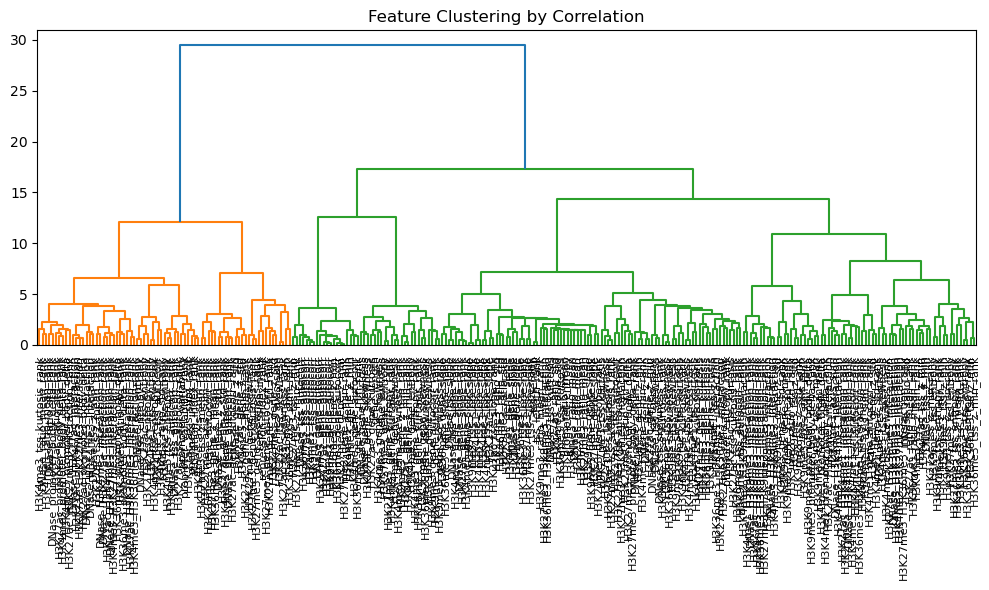

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# correlation matrix
corr = df_X1[features_pruned].corr().abs()

# hierarchical clustering
Z = linkage(corr, method="ward")

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=corr.columns, leaf_rotation=90, leaf_font_size=8)
plt.title("Feature Clustering by Correlation")
plt.tight_layout()
plt.show()

# cut the tree at a correlation distance threshold
max_d = 0.3  # smaller means stricter grouping
clusters = fcluster(Z, t=max_d, criterion='distance')
cluster_df = pd.DataFrame({'feature': corr.columns, 'cluster': clusters})


In [91]:
clusters

array([ 59, 171, 134,  93,  91,  86, 255, 116, 154, 174,  30,  80,  60,
       172, 132,  94,  92,  82, 252, 127, 197,  72,  32,  78,  61, 169,
       133, 190,  96, 105,  87, 253, 125, 243, 241,  40,  36,  68,  83,
       157, 191,  65,  98,  85,  75, 138, 162, 161, 262, 163,  84, 114,
       188, 107,  83, 268, 136, 153, 177, 266,  79, 238,  90, 135,  97,
       100,  81, 192, 123, 186, 184,  34,  77, 213, 211,  89, 155, 189,
       113,  81, 222, 215, 259, 122, 182, 180, 257,  77,  95, 140, 146,
       251, 147, 144, 148, 145, 149, 129, 152, 130, 150, 131,  43, 151,
        66,  14,  15,  17, 244, 226, 206,  13,  11, 246, 229, 208, 247,
       245, 227, 207, 196, 168, 141, 193, 142, 201,  12,   9,  69, 165,
        73,  26, 228, 224, 218, 220,  54, 173, 120,  56,  16, 117, 176,
       175,  31,  41,  62,  55, 103, 118,  57,  18, 256, 128, 198,  72,
        33,  42, 170, 119, 106,  58, 254, 126,   3, 242,  38,  39,  51,
        70,  83, 158,  63,  64,  99,  71,  49,  76, 139, 159, 16

In [98]:
def remove_highly_correlated_features(X, threshold=0.95):
    """移除在同一個資料集中彼此高相關的特徵"""
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    print(f"🧹 Removing {len(to_drop)} features (|r| > {threshold})")
    return X.drop(columns=to_drop), to_drop


# ============================================================
# 同時對 X1、X2 執行
# ============================================================
X1 = df_X1[features_pruned]
X2 = df_X2[features_pruned]

# 分別執行去除
X1_pruned, dropped_X1 = remove_highly_correlated_features(X1, threshold=0.95)
X2_pruned, dropped_X2 = remove_highly_correlated_features(X2, threshold=0.95)

# 🔗 合併兩邊要刪的 feature 名稱（union）
dropped_union = set(dropped_X1) | set(dropped_X2)

# 🔄 從 features_pruned 中移除這些特徵
features_pruned_2 = [f for f in features_pruned if f not in dropped_union]

print(f"\n✅ After cross-dataset pruning:")
print(f"   X1 shape: {X1_pruned.shape[1]} → {len(features_pruned)} kept")
print(f"   X2 shape: {X2_pruned.shape[1]} → {len(features_pruned)} kept")
print(f"   Removed {len(dropped_union)} features (union of X1 & X2)")

# # 可選：也更新實際的 pruned DataFrame
# df_X1_pruned = df_X1[features_pruned]
# df_X2_pruned = df_X2[features_pruned]


🧹 Removing 2 features (|r| > 0.95)
🧹 Removing 8 features (|r| > 0.95)

✅ After cross-dataset pruning:
   X1 shape: 275 → 277 kept
   X2 shape: 269 → 277 kept
   Removed 10 features (union of X1 & X2)


In [96]:
dropped

['DNase_tss_entropy_rank',
 'H3K27ac_tss_skewness_rank',
 'H3K27me3_gene_skewness_rank',
 'H3K27me3_gene_entropy_rank',
 'H3K36me3_gene_skewness_rank',
 'H3K4me1_gene_skewness_rank',
 'H3K9me3_gene_skewness_rank',
 'H3K9me3_tss_z_std_rank']

In [94]:
dropped

['H3K9me3_gene_autocorr', 'H3K27me3_gene_z_min_rank']

In [76]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# ============================================================
# CONFIG
# ============================================================
TARGETS = ["gex", "gex_rank"]
TOP_N = 300

# ============================================================
# COMPUTE FEATURE–TARGET CORRELATION
# ============================================================
corr_rows = []

for feature in X.columns:
    for target in TARGETS:
        valid_mask = df_train[[feature, target]].dropna()
        if len(valid_mask) < 3:
            continue

        x = valid_mask[feature].values
        y = valid_mask[target].values

        pearson_r, _ = pearsonr(x, y)
        spearman_r, _ = spearmanr(x, y)

        corr_rows.append({
            "feature": feature,
            "target": target,
            "pearson_r": pearson_r,
            "spearman_r": spearman_r
        })

df_corr = pd.DataFrame(corr_rows)

# ============================================================
# SELECT TOP 50 FOR EACH TARGET
# ============================================================
top_features = {}

for target in TARGETS:
    top_feats = (
        df_corr[df_corr["target"] == target]
        .assign(abs_spearman=lambda d: d["spearman_r"].abs())
        .sort_values("abs_spearman", ascending=False)
        .head(TOP_N)["feature"]
        .tolist()
    )
    top_features[target] = top_feats
    print(f"\n===== 🔝 Top {TOP_N} features correlated with {target} =====")
    print("\n".join(top_feats))

# ============================================================
# UNION (UNIQUE) FEATURES
# ============================================================
unique_features = sorted(set(top_features["gex"]) | set(top_features["gex_rank"]))
print(f"\n🧩 Total unique features from both targets: {len(unique_features)}")

# # Optional: export for training / feature selection
# pd.Series(unique_features, name="selected_features").to_csv(
#     "top50_union_features.tsv", sep="\t", index=False
# )
# print("💾 Saved → top50_union_features.tsv")



===== 🔝 Top 300 features correlated with gex =====
DNase_tss_z_std
DNase_tss_z_mean_rank
DNase_tss_z_mean
DNase_tss_autocorr_rank
DNase_tss_autocorr
openness_index_rank
H3K27ac_tss_z_std_rank
H3K27ac_tss_z_std
H3K4me3_axis_sum_rank
H3K4me3_tss_z_std
H3K27ac_axis_sum_rank
DNase_promoter_body_delta_rank
H3K4me3_tss_z_mean
H3K4me3_tss_z_mean_rank
H3K27ac_tss_z_mean
H3K27ac_tss_z_mean_rank
DNase_H3K4me3_interaction
DNase_H3K4me3_interaction_rank
H3K4me3_tss_autocorr
balance_H3K27
balance_H3K27_rank
promoter_variability_rank
promoter_variability
H3K4me3_tss_entropy
DNase_ratio_std_rank
DNase_ratio_std
DNase_tss_entropy_rank
DNase_tss_entropy
balance_H3K4_rank
DNase_H3K27me3_interaction_rank
DNase_H3K27me3_interaction
H3K4me3_gene_z_std
H3K27ac_tss_autocorr
H3K27ac_tss_autocorr_rank
H3K36me3_promoter_body_delta
H3K36me3_promoter_body_delta_rank
H3K4me3_gene_z_max
H3K27ac_tss_entropy_rank
H3K27ac_tss_entropy
DNase_H3K36me3_interaction_rank
DNase_H3K36me3_interaction
H3K4me3_gene_z_mean
H3K4m